Классификация и детекция кошечек и собак
В этом варианте использую предобученную модель FasterRCNN_Resnet50

Снова обновляем модуль до необходимой версии

In [1]:
pip uninstall albumentations

Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12


In [2]:
pip install albumentations # package >= '0.5.1'

     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 952kB 11.8MB/s 
     |████████████████████████████████| 37.6MB 1.4MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [3]:
import albumentations as A
A.__version__

'0.5.2'

In [4]:
# монтируем гугл диск с данными
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/MyDrive/cats_dogs_dataset.zip

In [6]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [7]:
import numpy as np
import pandas as pd
import os
from os import path

from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset , DataLoader

import time
import datetime

In [8]:
# загрузим гогтовый датасет подготовленный в предыдущей работе
cats_dogs_data = pd.read_csv('/content/gdrive/MyDrive/cats_dogs_origin.csv')

Загружаем модель предобученную на датасете COCO

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
model_torch = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Сразу создам даталоадер на основе датафрейма

In [11]:
# будем использовать классы
class_names ={'Cat': 1, 'Dog': 2, 'None': 0}

# для этого вернем собачкам класс 2
cats_dogs_data.target = [2 if x == 0 else x for x in cats_dogs_data.target]

# посмотрим на датасет
cats_dogs_data

,Unnamed: 0,idx,img_name,target,xmin,ymin,xmax,ymax
0,0,0,data/Abyssinian_1.jpg,1,333,72,425,158
1,1,1,data/Abyssinian_10.jpg,1,72,105,288,291
2,2,2,data/Abyssinian_100.jpg,1,151,71,335,267
3,3,3,data/Abyssinian_101.jpg,1,54,36,319,235
4,4,4,data/Abyssinian_102.jpg,1,23,27,325,320
...,...,...,...,...,...,...,...,...
3380,3380,3380,data/yorkshire_terrier_186.jpg,2,208,32,356,231
3381,3381,3381,data/yorkshire_terrier_187.jpg,2,187,49,317,181
3382,3382,3382,data/yorkshire_terrier_188.jpg,2,94,36,378,263
3383,3383,3383,data/yorkshire_terrier_189.jpg,2,274,84,402,207


In [12]:
from cd_dataset import Cats_and_Dogs
train_dataset = Cats_and_Dogs(cats_dogs_data, False)

In [13]:
X = cats_dogs_data.idx
y = cats_dogs_data.target

train_idx, val_idx, _, _ = train_test_split(X, y, test_size = 0.2, stratify = y)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size = 16, sampler = train_idx, collate_fn = collate_fn)
valid_loader =  DataLoader(train_dataset, batch_size = 16, sampler = val_idx, collate_fn = collate_fn)

**Теперь попробуем модель в действии:**
По выбранной картинке сделаем детекцию объектов, для этого загрузим необходимые бибилиотеки и сначала прост посмотрим на изображение

In [14]:
from utils import show_random_pict, plot_img_fastrcnn

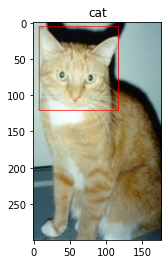

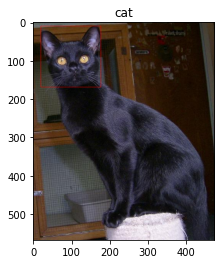

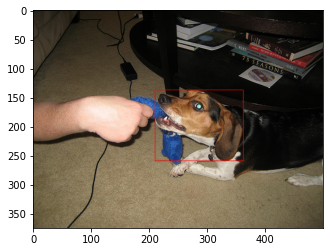

In [15]:
# вспомним как выглядят картинки в данных
for i in range(3):
    show_random_pict(cats_dogs_data)

**Делаем предсказание на предобученной модели**
для этого берем случайную картинку

In [16]:
random_image = np.random.choice(range(len(cats_dogs_data)))
img_path = cats_dogs_data.loc[random_image].img_name

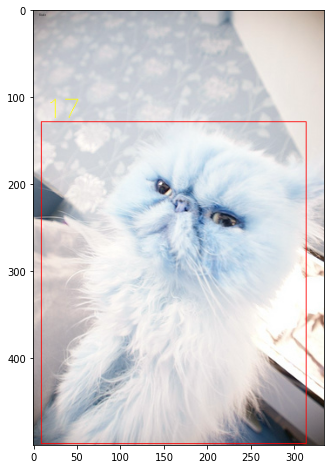

In [17]:
img_with_boxes = plot_img_fastrcnn(img_path, model_torch)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Итак, опробовали предобученную модель. Работает она хорошо, предсказывает животных и достаточно хорошо целиком детектирует их на изображениях. Теперь необходимо переучить ее с датасета COCO на новый датасет, чтоб модель детектировала и классифицировала только нужные нам объекты. 

Для начала попробуем использовать FasterRCNN **не** предобученную

In [18]:
def create_model(pretrain = True):
    # та же модель что была в начале ноутбука
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrain)
    # количество классов которое нам нужно
    num_classes = 3

    # получаем входные характеристики классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # и меняем предобученную "голову" сетки
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Я взял **не** предобученную модель для наглядности изменения метрик в процессе обучения.
Так же часть эксперимента поставлена на уже предобученной на датасете СОСО модели.

In [19]:
my_model = create_model(pretrain = False).to(device) 

optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Обучение модели на наших данных с нуля без увеличения или балансировки датасета

In [20]:
from train_val import train_frcnn, validate_frcnn

In [21]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train_frcnn(train_loader, my_model, optimizer, device)
    mean_acc, mean_iou = validate_frcnn(valid_loader, my_model, device)
    print(f"Эпоха #{epoch} train_loss: {train_loss}, mean accuracy: {mean_acc}, mIoU: {mean_iou}")   
    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx)}, валидационного сета : {len(val_idx)}")

Эпоха #1 train_loss: 0.3405570216038648, mean accuracy: 0.69593, mIoU: 0.39881
Время затрачено на эпоху :  0:05:11.129396

Эпоха #2 train_loss: 0.2137716261779561, mean accuracy: 0.69593, mIoU: 0.43422
Время затрачено на эпоху :  0:05:10.180004

Эпоха #3 train_loss: 0.2136801698628594, mean accuracy: 0.70465, mIoU: 0.48579
Время затрачено на эпоху :  0:05:09.995431

Эпоха #4 train_loss: 0.21418259117533178, mean accuracy: 0.72645, mIoU: 0.47648
Время затрачено на эпоху :  0:05:10.300157

Эпоха #5 train_loss: 0.21006277019486708, mean accuracy: 0.70174, mIoU: 0.48243
Время затрачено на эпоху :  0:05:10.644598

Эпоха #6 train_loss: 0.21061764911693684, mean accuracy: 0.725, mIoU: 0.50587
Время затрачено на эпоху :  0:05:10.748076

Эпоха #7 train_loss: 0.2116462840753443, mean accuracy: 0.77297, mIoU: 0.50054
Время затрачено на эпоху :  0:05:10.406700

Эпоха #8 train_loss: 0.20478266591534894, mean accuracy: 0.82093, mIoU: 0.52985
Время затрачено на эпоху :  0:05:10.458780

Эпоха #9 train

Посмотрим предсказание модели на случайной картинке из валидционной выборки

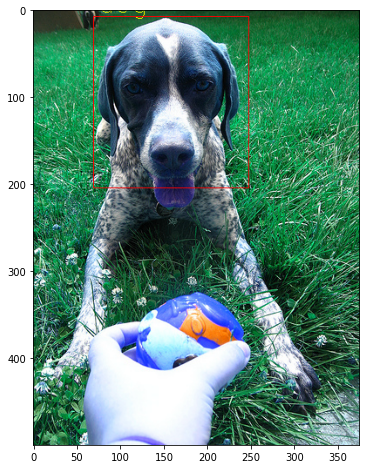

In [22]:
random_image = np.random.choice(val_idx)
img_path = cats_dogs_data.loc[random_image].img_name

img_with_boxes = plot_img_fastrcnn(img_path, my_model)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

И еще одну картинку посмотрим

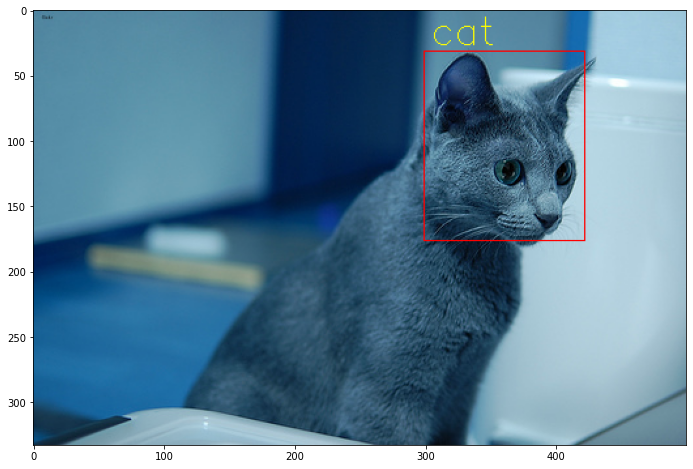

In [25]:
random_image = np.random.choice(val_idx)
img_path = cats_dogs_data.loc[random_image].img_name
img_with_boxes = plot_img_fastrcnn(img_path, my_model)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

По тестовым картинкам видим очень неплохой результат, несмотря на небольшие показатели метрик. Путем перебора разных картинок, попадаются те, на которых модель никого вообще не находит. В таких моментах срабатывает "заглушка" и mIoU добавляет 0 в общий счет и в классы так же добавляется 0.

Снова возьмем ту же модель не предобученную

In [30]:
extra_model = create_model(pretrain = False).to(device)  # создаем новую модель предобученную на датасете COCO

extra_optimizer = torch.optim.SGD(extra_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

Загрузим из прошлой работы расширенный датасет и создадим новый даталоадер

In [31]:
cats_dogs_data_extend = pd.read_csv('/content/gdrive/MyDrive/cats_dogs_extended.csv')

In [32]:
train_dataset_extend = Cats_and_Dogs(cats_dogs_data_extend, False)

X_ex = cats_dogs_data_extend.idx
y_ex = cats_dogs_data_extend.target

train_idx_ex, val_idx_ex, _, _ = train_test_split(X_ex, y_ex, test_size = 0.2, stratify = y_ex)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader_ex = DataLoader(train_dataset_extend, batch_size = 16, sampler = train_idx_ex, collate_fn = collate_fn)
valid_loader_ex =  DataLoader(train_dataset_extend, batch_size = 16, sampler = val_idx_ex, collate_fn = collate_fn)

In [33]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train_frcnn(train_loader_ex, extra_model, extra_optimizer, device)
    mean_acc, mean_iou = validate_frcnn(valid_loader_ex, extra_model, device)
    print(f"Эпоха #{epoch} train_loss: {train_loss}, mean accuracy: {mean_acc}, mIoU: {mean_iou}")   
    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx)}, валидационного сета : {len(val_idx)}")

Эпоха #1 train_loss: 0.13634587590121947, mean accuracy: 0.52644, mIoU: 0.48253
Время затрачено на эпоху :  0:31:42.452695

Эпоха #2 train_loss: 0.10327854316785802, mean accuracy: 0.53726, mIoU: 0.49675
Время затрачено на эпоху :  0:31:39.326047

Эпоха #3 train_loss: 0.09956682036947836, mean accuracy: 0.58317, mIoU: 0.471
Время затрачено на эпоху :  0:31:40.975419

Эпоха #4 train_loss: 0.09719125784057028, mean accuracy: 0.60745, mIoU: 0.47164
Время затрачено на эпоху :  0:31:45.580223

Эпоха #5 train_loss: 0.09547136507375147, mean accuracy: 0.64038, mIoU: 0.45247
Время затрачено на эпоху :  0:31:44.020186

Эпоха #6 train_loss: 0.09253447524764959, mean accuracy: 0.63918, mIoU: 0.45099
Время затрачено на эпоху :  0:31:45.477888

Эпоха #7 train_loss: 0.09155321909741587, mean accuracy: 0.66611, mIoU: 0.43618
Время затрачено на эпоху :  0:31:47.159910

Эпоха #8 train_loss: 0.09139487654214999, mean accuracy: 0.64327, mIoU: 0.4475
Время затрачено на эпоху :  0:31:45.380166

Эпоха #9 tr

In [34]:
# В предыдущей ячейке увидел неточность в выводе количества данных, перезапускать не стал
print(f"Размер тренировочного сета : {len(train_idx_ex)}, валидационного сета : {len(val_idx_ex)}")

Размер тренировочного сета : 16592, валидационного сета : 4148


Посмотрим как предсказывает модель обученная на расширенном датасете

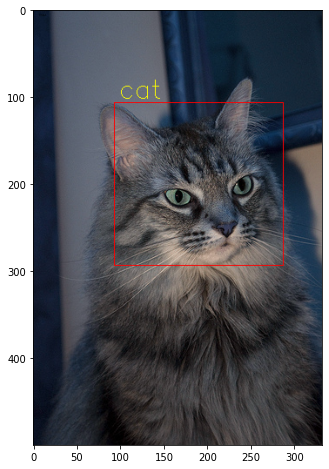

In [35]:
random_image = np.random.choice(val_idx)
img_path = cats_dogs_data.loc[random_image].img_name

img_with_boxes = plot_img_fastrcnn(img_path, my_model)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

И еще один тест

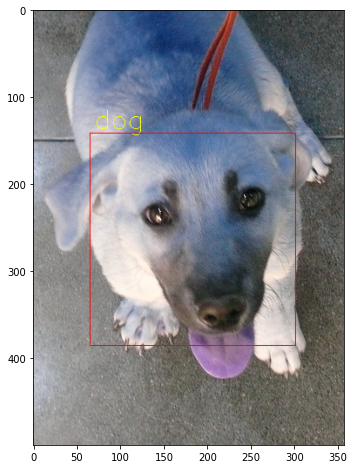

In [36]:
random_image = np.random.choice(val_idx)
img_path = cats_dogs_data.loc[random_image].img_name

img_with_boxes = plot_img_fastrcnn(img_path, my_model)
fig = plt.figure(figsize=(18,8))
plt.imshow(img_with_boxes.astype('uint'));

Из этого опыта видно, что использование предобученной модели ускоряет ее схождение. И в сравнении с моделью, написанной мной в первом решении, FasterRCNN работает лучше и обучается быстрее.